# Real-Time Stream Simulation & Event Trigger

* Simulate a video stream using OpenCV
* Perform detection on every 3rd frame
* Trigger an alert (e.g., "Crowd Detected") if 3+ people appear in 5 consecutive frames
* Log alerts in .json or .txt format
* Plot a timeline of alert occurrences
* (Optional) Overlay alerts and export the output visuals

In [1]:
#importing necessary libraries
import cv2
import torch
from ultralytics import YOLO
import json
import matplotlib.pyplot as plt
from datetime import datetime, timedelta 
import pandas as pd
import numpy as np
from collections import deque 

In [2]:
# 1. People detection; more than 3 people in one frame in 5 consecutive frames.
def detect_people_in_frame(frame, yolo_model):
    current_people_count = 0
    results = yolo_model(frame)

    for r in results:
        boxes = r.boxes # Bounding boxes
        names = yolo_model.names # Class names 

        for i, box in enumerate(boxes):
            class_id = int(box.cls[0])
            class_label = names[class_id]
            if class_label == 'person':
                current_people_count += 1
    return current_people_count

In [3]:
# 2. Function to create logs
def prepare_alert_log_entry(timestamp, frame_number, people_count_in_frame, people_threshold, consecutive_frames):
    alert_message = (f"Crowd Detected: {people_threshold}+ people ({people_count_in_frame} detected) "
                     f"in {consecutive_frames} consecutive frames.")
    log_entry = {"timestamp": timestamp, "frame_number": frame_number, "alert_message": alert_message, "people_count_in_frame": people_count_in_frame}
    return log_entry

In [4]:
# 3. Function to plot timeline of alert occurence
def plot_alert_timeline(timestamps_td):
    if not timestamps_td:
        print("No timestamps available for plotting timeline.")
        return
    
    times_in_seconds = [ts.total_seconds() for ts in timestamps_td]
    y_axis = [1] * len(times_in_seconds)
    plt.figure(figsize=(15, 5))
    plt.plot(times_in_seconds, y_axis, 'o', color='red', markersize=8, label='Crowd Alert')
    plt.yticks([])
    plt.xlabel('Time in Video (seconds)') # Updated label
    plt.title('Timeline of Crowd Alert Occurrences (Video Time)') # Updated title
    plt.grid(True, axis='x', linestyle='--', alpha=0.7)
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [5]:
# 4. Main function to bind and run all the tasks
def realtime_stream(video_path, model_name='yolov8n.pt', frame_skip=3, people_threshold=3, no_of_consecutive_frame=5, output_log_file="alerts_log.json"):
    yolo_model = YOLO(model_name)
    cap = cv2.VideoCapture(video_path)

    #to check if video path is correct or not
    if not cap.isOpened():
        print(f"Error: Could not open video {video_path}")
        return

    fps = cap.get(cv2.CAP_PROP_FPS)
    if fps == 0:
        fps = 30.0

    # creating all neccessary variables
    frame_count = 0
    consecutive_frames = 0
    alert_entries = []
    alert_timestamps_for_plot = [] 

    print(f"Starting video processing for: {video_path} (FPS: {fps:.2f})")

    # loop to process the video
    while True:
        ret, frame = cap.read()
        if not ret:
            print("Error occured while reading frame.")
            break

        if frame_count % frame_skip == 0:
            current_video_seconds = frame_count / fps
            current_video_timestamp_td = timedelta(seconds=current_video_seconds)

            # Format the timestamp 
            total_ms = int(current_video_timestamp_td.total_seconds() * 1000)
            hours = total_ms // (1000 * 60 * 60)
            minutes = (total_ms // (1000 * 60)) % 60
            seconds = (total_ms // 1000) % 60
            ms = total_ms % 1000
            video_timestamp_str = f"{hours:02}:{minutes:02}:{seconds:02}.{ms:03}"

            # function call to detect number of people in the frame
            current_people_count = detect_people_in_frame(frame, yolo_model)

            # Check alert condition
            if current_people_count >= people_threshold:
                consecutive_frames += 1
            else:
                consecutive_frames = 0

            if consecutive_frames >= no_of_consecutive_frame:
                # Function call to create logs
                log_entry = prepare_alert_log_entry(video_timestamp_str, frame_count, current_people_count, people_threshold, no_of_consecutive_frame)
                alert_entries.append(log_entry)
                alert_timestamps_for_plot.append(current_video_timestamp_td) # Store timedelta for plotting
                print(f"[ALERT] Video Time {video_timestamp_str} - Frame {frame_count}: {log_entry['alert_message']}")

                # Reset consecutive frame counter 
                consecutive_frames = 0

        frame_count += 1

    cap.release()

    # Function to write all the logs to json file
    if alert_entries:
        with open(output_log_file, "w") as f:
            json.dump(alert_entries, f, indent=4)
        print(f"Alert log saved to {output_log_file}")
    else:
        print("No alerts triggered. No log file created.")

    # Plot the timeline of alert occurrences
    if alert_timestamps_for_plot:
        plot_alert_timeline(alert_timestamps_for_plot)
    else:
        print("No alerts to plot on timeline.")


Starting video processing for: video-dataset/video-3.mp4 (FPS: 24.00)

0: 384x640 (no detections), 70.2ms
Speed: 4.7ms preprocess, 70.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 63.4ms
Speed: 2.3ms preprocess, 63.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 51.1ms
Speed: 1.5ms preprocess, 51.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 43.4ms
Speed: 1.7ms preprocess, 43.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 46.8ms
Speed: 1.8ms preprocess, 46.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 44.7ms
Speed: 1.6ms preprocess, 44.7ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 144.8ms
Speed: 2.1ms preprocess, 144.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 64

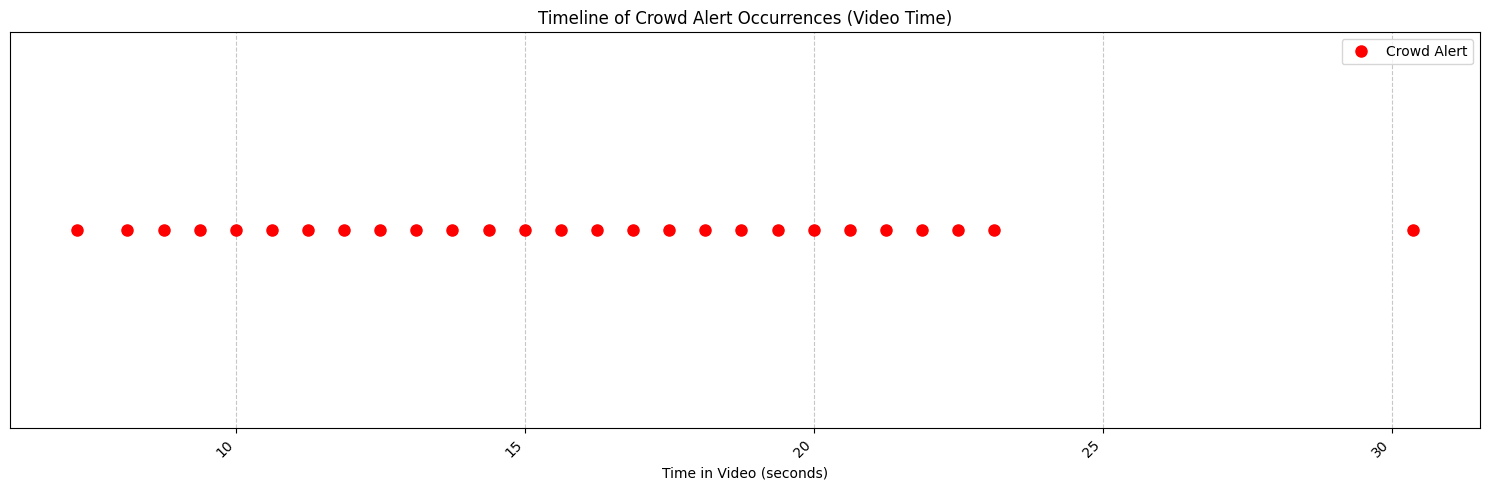

In [6]:
video_data="video-dataset/video-3.mp4"
yolo_model_version = 'yolov8n.pt' 

realtime_stream(
    video_path=video_data,
    model_name=yolo_model_version,
    frame_skip=3,
    people_threshold=3, 
    no_of_consecutive_frame=5, 
    output_log_file="alerts_log.json"
    )